In [1]:
import delphi.networks._utils.hooks as net_hooks
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch
import numpy as np
from delphi.explain.cka import *
import matplotlib.pyplot as plt

/Users/phisei/opt/anaconda3/envs/delphi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_data = MNIST('../../dl4ni/notebooks/data/', train=False, download=False, transform=ToTensor())

In [3]:
model_cnn = torch.load("../../dl4ni/notebooks/my_cnn_mnist/model.pth")
model_cnn.eval()
net_hooks.hook_net(model_cnn)

model_cnn2 = torch.load("../../dl4ni/notebooks/my_cnn2_mnist/model.pth")
model_cnn2.eval()
net_hooks.hook_net(model_cnn2)

In [4]:
activs_a, activs_b = {}, {}

for i in test_data.targets.unique():
    idx = np.where(test_data.targets == i)
    dl = DataLoader(Subset(test_data, idx[0][:200]), batch_size=5)

    for batch, (img, lbl) in enumerate(dl):
        a = model_cnn(img.float())
        activs_a = net_hooks.assign_activations(activs_a)
        a = model_cnn2(img.float())
        activs_b = net_hooks.assign_activations(activs_b)

In [29]:
activs_a['convlayer1'].shape

(2000, 16, 14, 14)

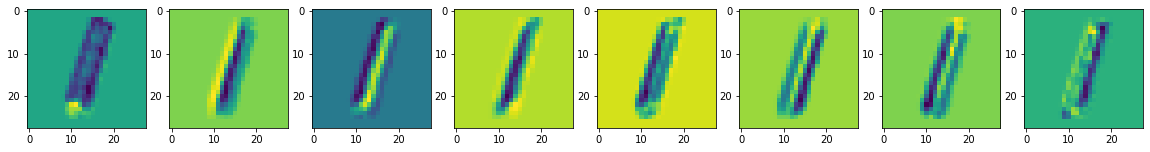

In [26]:
fig, axes = plt.subplots(1, 8, figsize=(20, 8))
for i in range(0, 8):
    axes[i].imshow(activs_a['convlayer0'][200, i, :, :])

## Plot channel correlation

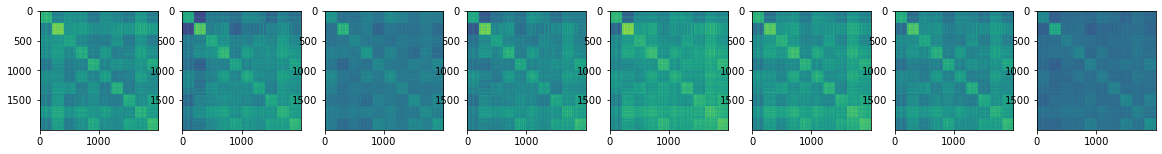

In [6]:
cka_mat = {}
fig, axes = plt.subplots(1, 8, figsize=(20,8))
key = 'convlayer0'
for i in range(0,8):
    r = np.corrcoef(np.reshape(activs_a[key][:, i, :, :], (len(activs_a[key]), np.prod(activs_a[key].shape[2:]))))
    axes[i].imshow(r)


## Plot within layer CKA

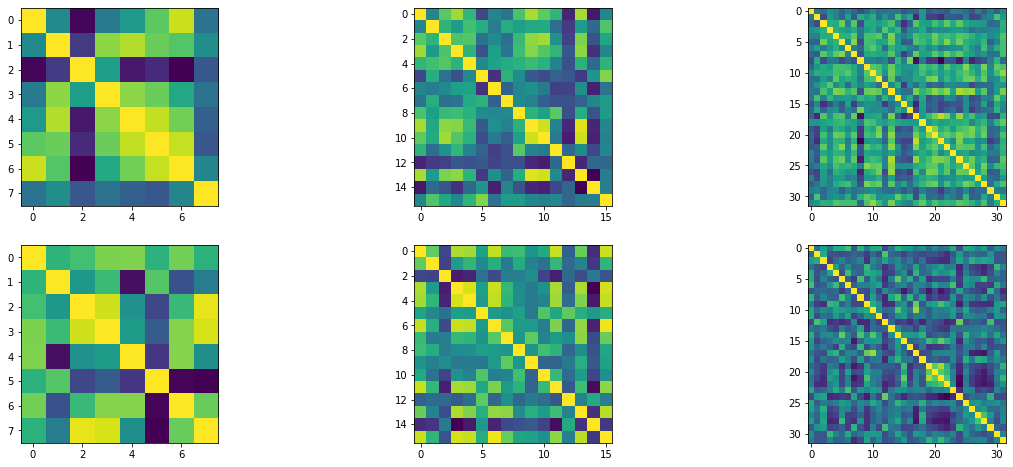

In [11]:
cka_mat = {}
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
for i, key in enumerate(activs_a.keys()):
    if "conv" in key:
        cka_mat[key] = get_within_layer_cka_matrix(activs_a[key])
        axes[0, i].imshow(cka_mat[key])
        cka_mat[key] = get_within_layer_cka_matrix(activs_b[key])
        axes[1, i].imshow(cka_mat[key])


## Plot pair-wise CKA between two networks

In [8]:
cka_mat = get_cka_matrix(activs_a, activs_b)

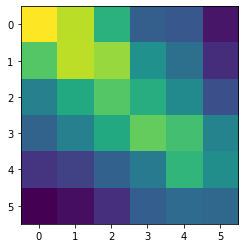

In [9]:
plt.imshow(cka_mat)